<a href="https://colab.research.google.com/github/TheBuilderHero/CMP_SCI_4340_Project_1_Group/blob/main/Final_Project_OverFitting_Using_datasets_withNormalization_GoodPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import needed Libraries

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download and decompress Data

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thebuilderherokota","key":"705cf075e6b380effd0f2494d5e39123"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
#! kaggle datasets list
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

100% 3.79G/3.79G [02:56<00:00, 21.8MB/s]
100% 3.79G/3.79G [02:56<00:00, 23.1MB/s]


In [9]:
!unzip -q /content/deepglobe-road-extraction-dataset.zip

In [10]:
!ls -l

total 3980156
-rw-r--r-- 1 root root         46 Nov 10  2020 class_dict.csv
-rw-r--r-- 1 root root 4074676823 Nov 10  2020 deepglobe-road-extraction-dataset.zip
-rw-r--r-- 1 root root         74 Apr 17 18:23 kaggle.json
-rw-r--r-- 1 root root     434416 Nov 10  2020 metadata.csv
drwxr-xr-x 1 root root       4096 Apr 16 13:23 sample_data
drwxr-xr-x 2 root root      36864 Apr 17 18:26 test
drwxr-xr-x 2 root root     450560 Apr 17 18:26 train
drwxr-xr-x 2 root root      49152 Apr 17 18:26 valid


In [11]:
#!ls -l test

In [12]:
#!ls -l valid

In [13]:
#!ls -l train

## Update file architechture

In [14]:
!cp /content/train/* /content/trainingdata/

cp: target '/content/trainingdata/' is not a directory


## Get min size information associated with picture data

In [15]:
from PIL import Image
filenames = []
sizes = []
index=1

# This is my path
paths = ["test", "valid", "train"]

# dirs=directories
for path in paths:
  for (root, dirs, file) in os.walk(path):
    for f in file:
        if '.jpg' in f:
            filenames.append(f)
            filename = root + "/" + f
            sizes.append([Image.open(filename, 'r').size,index])
            index += 1


print(sizes)
print(max(sizes))
print(min(sizes))

# Define the target size
value = min(sizes)
print(value[0])
target_size = value[0]  # Specify the new width and height

[[(1024, 1024), 1], [(1024, 1024), 2], [(1024, 1024), 3], [(1024, 1024), 4], [(1024, 1024), 5], [(1024, 1024), 6], [(1024, 1024), 7], [(1024, 1024), 8], [(1024, 1024), 9], [(1024, 1024), 10], [(1024, 1024), 11], [(1024, 1024), 12], [(1024, 1024), 13], [(1024, 1024), 14], [(1024, 1024), 15], [(1024, 1024), 16], [(1024, 1024), 17], [(1024, 1024), 18], [(1024, 1024), 19], [(1024, 1024), 20], [(1024, 1024), 21], [(1024, 1024), 22], [(1024, 1024), 23], [(1024, 1024), 24], [(1024, 1024), 25], [(1024, 1024), 26], [(1024, 1024), 27], [(1024, 1024), 28], [(1024, 1024), 29], [(1024, 1024), 30], [(1024, 1024), 31], [(1024, 1024), 32], [(1024, 1024), 33], [(1024, 1024), 34], [(1024, 1024), 35], [(1024, 1024), 36], [(1024, 1024), 37], [(1024, 1024), 38], [(1024, 1024), 39], [(1024, 1024), 40], [(1024, 1024), 41], [(1024, 1024), 42], [(1024, 1024), 43], [(1024, 1024), 44], [(1024, 1024), 45], [(1024, 1024), 46], [(1024, 1024), 47], [(1024, 1024), 48], [(1024, 1024), 49], [(1024, 1024), 50], [(1024, 

## Load image data and Rescale pictures to smallest picture size

In [16]:
#!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-p8pqfgmc
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-p8pqfgmc
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-py3-none-any.whl size=43609 sha256=c9ad398a865a5a7fbf825f9b5b0e64270e35651b43d5b3cd02b8ea9999ad9e47
  Stored in directory: /tmp/pip-ephem-wheel-cache-ss233r6a/wheels/72/0b/c7/3f6b26f2d789c712867e02502e1f1b740091f8615f32a9f870
Successfully built Keras-Preprocessing


In [17]:
# this loads gets all the file names for both the pictures and their masks and puts them into a dataframe.
metadata_df = pd.read_csv(os.path.join("./", 'metadata.csv'))
class_df = pd.read_csv(os.path.join("./", 'class_dict.csv'))
metadata_train_df = metadata_df[metadata_df["split"] == "train"]
metadata_test_df = metadata_df[metadata_df["split"] == "test"]

#remove the plit column now that it is not needed:
metadata_train_df.drop("split",inplace=True,axis=1)
metadata_test_df.drop("split",inplace=True,axis=1)

#test does not need the mask path since it is gonna generate them:
metadata_test_df.drop("mask_path",inplace=True,axis=1)

#fix indexing:
metadata_train_df = metadata_train_df.reset_index()
metadata_test_df = metadata_test_df.reset_index()

#metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]

# get full path to the images
metadata_train_df['sat_image_path'] = metadata_train_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_train_df['mask_path'] = metadata_train_df['mask_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_test_df['sat_image_path'] = metadata_test_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))

<ipython-input-17-f67eeb8151c2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train_df.drop("split",inplace=True,axis=1)
<ipython-input-17-f67eeb8151c2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("split",inplace=True,axis=1)
<ipython-input-17-f67eeb8151c2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("mask_path",inplace=True,axis=1)


#### Shuffle and split data

In [18]:
metadata_train_df = metadata_train_df.sample(frac=1).reset_index(drop=True)

In [19]:
valid_df = metadata_train_df.sample(frac=0.2,random_state=42)
train_df = metadata_train_df.drop(valid_df.index)

#### Get class data

In [20]:
class_names = class_df["name"].tolist()

In [21]:
RGB_values = class_df[["r","g","b"]].values.tolist()

In [22]:
Class_Type = ['background', 'road']

In [23]:
# Makes the class values 0 and 1
Class_Indices = [class_names.index(cls.lower()) for cls in Class_Type]

In [24]:
Class_RGB_Values = np.array(RGB_values)[Class_Indices]
# Creates a matrix of class RGB values

## Image Loading and Processing

In [25]:
import cv2
import pandas as pd
import tensorflow as tf

data_size = [3000,256,256]

reduced_data = train_df[0:data_size[0]].reset_index(drop=True)



sat_images = []
mask_images = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images.append(img)
    mask_images.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [26]:
reduced_data = valid_df[0:data_size[0]].reset_index(drop=True)

sat_images_valid = []
mask_images_valid = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images_valid.append(img)
    mask_images_valid.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [27]:
print(sat_images[0])
#print(mask_images[0])

[[[0.60392157 0.50980392 0.43137255]
  [0.46666667 0.40784314 0.34117647]
  [0.41568627 0.38431373 0.31764706]
  ...
  [0.30980392 0.36470588 0.2627451 ]
  [0.31372549 0.37647059 0.2627451 ]
  [0.30588235 0.37254902 0.2627451 ]]

 [[0.49019608 0.4        0.34117647]
  [0.41960784 0.36470588 0.31372549]
  [0.31764706 0.29019608 0.24313725]
  ...
  [0.29411765 0.35686275 0.24705882]
  [0.30588235 0.36078431 0.25098039]
  [0.31372549 0.36862745 0.26666667]]

 [[0.56862745 0.50980392 0.44705882]
  [0.3372549  0.30980392 0.25098039]
  [0.3254902  0.3372549  0.27843137]
  ...
  [0.30588235 0.36862745 0.25882353]
  [0.30588235 0.36862745 0.25882353]
  [0.31372549 0.36470588 0.2627451 ]]

 ...

 [[0.32941176 0.39215686 0.27843137]
  [0.33333333 0.39215686 0.27843137]
  [0.3372549  0.39607843 0.28235294]
  ...
  [0.34509804 0.38039216 0.28627451]
  [0.34509804 0.37647059 0.28235294]
  [0.35294118 0.38431373 0.29019608]]

 [[0.31764706 0.37647059 0.2627451 ]
  [0.31372549 0.37254902 0.25882353]


### Start by splitting and shuffling the data

In [28]:
# Shuffle DataFrame
#metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Split the data 80 for training and 20 for testing
#valid_df = metadata_df.sample(frac=0.2, random_state=42)
#train_df = metadata_df.drop(valid_df.index)
#len(train_df), len(valid_df)
#metadata_df.head()

Image shape: 3000, Mask shape: 3000


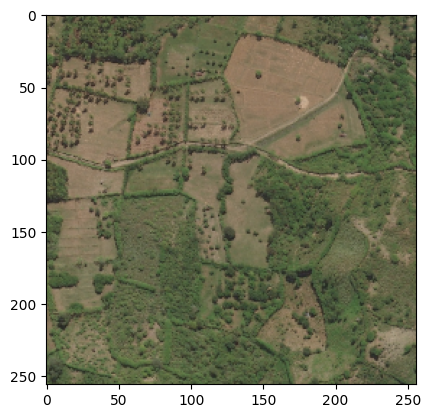

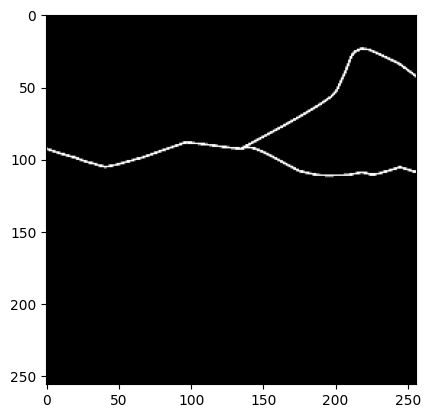

In [29]:
import random
# Setup the dataset # Note that the class_rgb_values is being set to the RGB values of the input classes values.
random_idx = random.randint(0, len(sat_images)-1)
#image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
print(f"Image shape: {len(sat_images)}, Mask shape: {len(mask_images)}")
import matplotlib.pyplot as plt
plt.imshow(sat_images[random_idx])
plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
mask_single_channel = mask_images[random_idx]
plt.imshow(mask_single_channel, cmap='gray')
plt.show()

#plt.imshow(mask)
#plt.show()

## Build the model

In [30]:
model = Sequential()
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape = (data_size[1],data_size[2],3), padding='same' ))
print(model.output_shape)
print(model.input_shape)
#model.add( MaxPool2D(3, 3) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu' , padding='same') )
model.add(BatchNormalization())
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 128, ( 5, 5 ), activation = 'relu', padding='same' ) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu', padding='same' ) )
model.add(BatchNormalization())
#model.add( MaxPool2D(2, 2) )

model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 7, 7 ), activation = 'relu', padding='same' ) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))

#duplicated for complexity
model.add( Conv2D( 128, ( 7, 7 ), activation = 'relu', input_shape = (data_size[1],data_size[2],3), padding='same' ))
model.add(BatchNormalization())
#model.add( MaxPool2D(3, 3) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu' , padding='same') )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', padding='same') )
model.add(BatchNormalization())
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', padding='same') )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', padding='same') )
#model.add( Conv2D( 8, ( 3, 3 ), activation = 'relu', padding='same' ) )
#model.add( Flatten() )
#model.add( Dense( 512, activation = 'relu' ) )
#model.add( Dense( 256, activation = 'sigmoid' ) )


model.add( Conv2D( 1, ( 3, 3 ), activation = 'sigmoid', padding='same' ) )

(None, 256, 256, 32)
(None, 256, 256, 3)


In [31]:
from keras.callbacks import ModelCheckpoint

# Define the filepath for saving the weights
filepath = "model_weights.h5"

# Load the saved weights into the model
#model.load_weights("model_weights.h5")

# Define a ModelCheckpoint callback to save the weights
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

## Compile the model and overfit it to the Data

In [32]:
model.compile( optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [ 'accuracy' ])
model.summary()
# Train using the training set and evaluate using the validation set
#Removed :: validation_data = valid_generator, and , callbacks=[checkpoint]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     204928    
                                                        

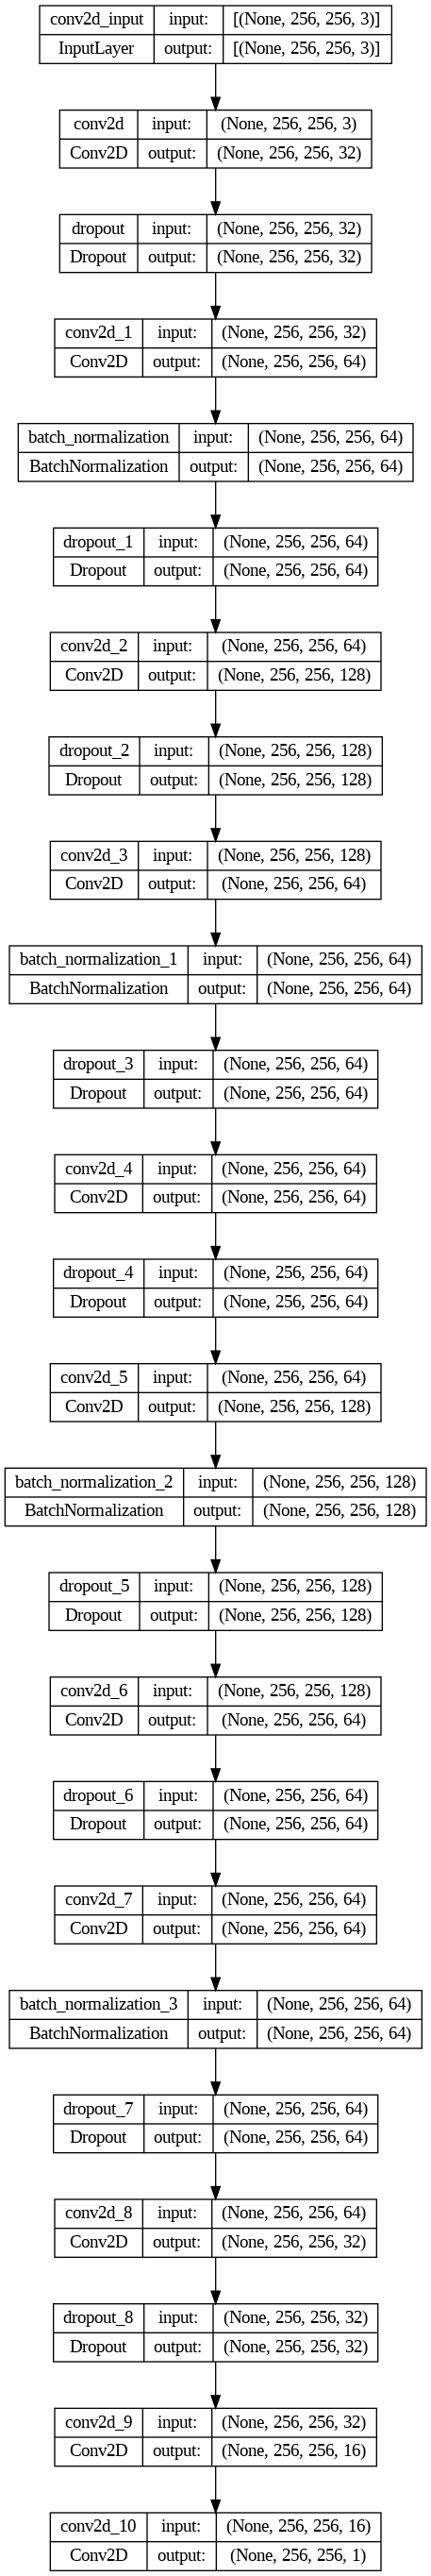

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:


sat_images = np.array(sat_images)
mask_images = np.array(mask_images)

sat_images_reshaped = sat_images.reshape((-1, 256, 256, 3))
mask_images_reshaped = mask_images.reshape((-1, 256, 256, 1))

#train_generator_one_hot.element_spec
history = model.fit(sat_images,mask_images, batch_size=2, epochs = 5, callbacks=[checkpoint], validation_split=0.2)

Epoch 1/5
1200/1200 [==============================] - 388s 309ms/step - loss: 53.1360 - accuracy: 0.7928 - val_loss: 51.3754 - val_accuracy: 0.9538
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1200/1200 [==============================] - 374s 312ms/step - loss: 47.6519 - accuracy: 0.9552 - val_loss: 49.3861 - val_accuracy: 0.9570
Epoch 3/5
1200/1200 [==============================] - 373s 311ms/step - loss: 46.0557 - accuracy: 0.9593 - val_loss: 48.9164 - val_accuracy: 0.9592
Epoch 4/5
1200/1200 [==============================] - 372s 310ms/step - loss: 45.0867 - accuracy: 0.9609 - val_loss: 49.5265 - val_accuracy: 0.9594
Epoch 5/5
1200/1200 [==============================] - 372s 310ms/step - loss: 44.3644 - accuracy: 0.9616 - val_loss: 47.1657 - val_accuracy: 0.9618


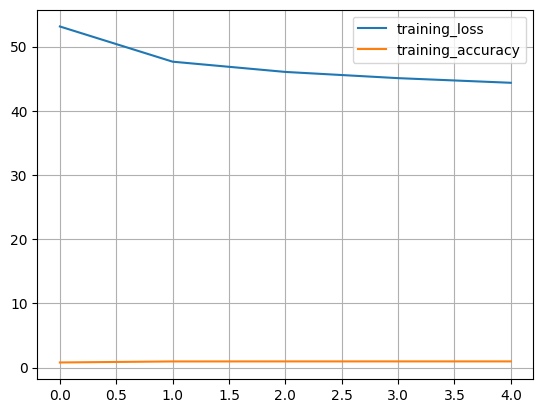

In [36]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.plot(history.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [37]:
# Load the saved weights into the model
model.load_weights("model_weights.h5")

In [38]:
#sat_images = np.array(sat_images)
#mask_images = np.array(mask_images)

sat_images_reshaped = sat_images.reshape((-1, 256, 256, 3))
#mask_images_reshaped = mask_images.reshape((-1, 256, 256, 1))

#pred = model.predict(sat_images[1,:,:,:])
#pred = model.predict(sat_images_valid)
pred = model.predict(sat_images_reshaped[0:10,:,:,:])

1/1 [==============================] - 10s 10s/step


Image shape: 3000, Mask shape: 10


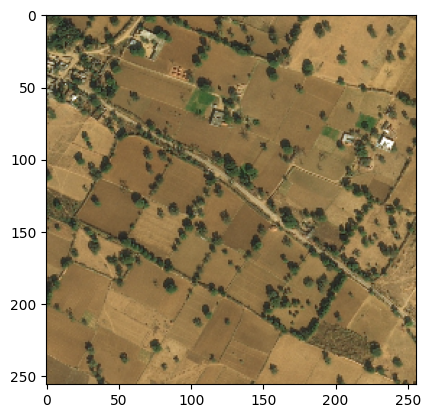

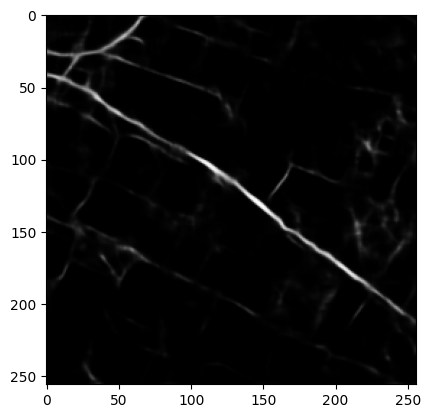

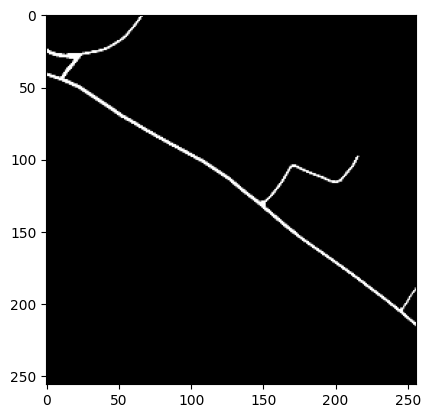

In [50]:
random_idx = random.randint(0, 10-1)
#image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
print(f"Image shape: {len(sat_images_reshaped)}, Mask shape: {len(pred)}")
import matplotlib.pyplot as plt
plt.imshow(sat_images_reshaped[random_idx])
plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
mask_single_channel = pred[random_idx]
plt.imshow(mask_single_channel, cmap='gray')
plt.show()

# Convert multi-channel mask to single-channel mask just for the sake of showing it.
mask_single_channel = mask_images_reshaped[random_idx]
plt.imshow(mask_single_channel, cmap='gray')
plt.show()

## Convert to HTML this notebook

In [ ]:
%%shell
jupyter nbconvert --to html /content/TestProject_OverFitting_AllData.ipynb